**Задача классификации тарелок по фотографии на чистые / грязые**

- Финальная метрика качества - точность (accuracy).
- Соотношение классов в тесте 0,67 (грязные) 0,33 (чистые), поэтому если всех обозначить грязными даст score 0.67
- базовая реализация ниже дает **Score 0.82**

- при работе прямо на каггле данные в `../input`
- мы конечно так делать не будем, поэтому `./input` и везде где точка, на каггле аналогично без нее

In [75]:
NAME = "unfreeze"

INPUT_DIR = "./input" # "../input"
WORKING_DIR = "./kaggle/working/" # "/kaggle/working/"

In [76]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(f"Content of {INPUT_DIR}: {os.listdir(INPUT_DIR)}")
# Any results you write to the current directory are saved as output.

Content of ./input: ['plates.zip', 'sample_submission.csv']


In [77]:
import zipfile

DATA_ROOT = os.path.join(WORKING_DIR, 'plates')

if not os.path.isdir(DATA_ROOT): 
   # Extract all JPG of zip file
   with zipfile.ZipFile(os.path.join(INPUT_DIR, 'plates.zip')) as zip_obj:
      [zip_obj.extract(file, WORKING_DIR) for file in zip_obj.namelist() if file.endswith("jpg")]
    
print(f"Content of {DATA_ROOT}: {os.listdir(DATA_ROOT)}")

Content of ./kaggle/working/plates: ['test', 'train']


Тренировочный набор маленький: 20 размеченных изображений
- валидационный набор отдельно не делаем, валидируем на аугментированных данных

In [78]:
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
TEST_DIR = 'test'

## Итераторы

Для папок с кортинками есть итератор `torchvision.datasets.ImageFolder`
- метки классов он ставит по папкам (одна папка - один класс)
- выдает кортежи (тензор, метка)
- тензоры он делает, применяя к кадру переданное ему **преобрзование**
  - если не передать преобрзования, то будет выдавать тип `PIL.Image.Image`

Преобразование кадра в тензор:
- `transforms.Compose` последовательно применяет преобразования, в т.ч.:
  - `transforms.ToTensor` - PIL.Image или numpy.ndarray в торч-тензор (вещественный)
    - прост [0, 255] -> [0., 1.] и размерности HxWxC -> CxHxW 
    - правильно раскидывает каналы в зависимости от режима картинки (RGB, YCbCr, RGBA, CMYK и др.)
  - `transforms.Normalize` - константы, на которые нужно отнормировать картинки (cmean, std)
    - output[channel] = (input[channel] - mean[channel]) / std[channel]
    - это параметры изображений ImageNet, на которых обучался ResNet

Датасет минимальный - нужна аугментация:
- например, нет красных тарелков, а в тесте они могут быть - нужно добавить такое преобрзование и т.д.

Итератор данных `torch.utils.data.DataLoader`
- будет выдавать батчи из предыдущего итератора, который как раз случайно трансформирует исходные изображения

In [79]:
# константы для ImageNet
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

In [80]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms, models

from sklearn.model_selection import train_test_split

CLASS_NAMES = ['cleaned', 'dirty']

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=90, fill=255),
    transforms.CenterCrop(180),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(hue=(0.1, 0.2)), # brightness, contrast, saturation and hue
    # transforms.RandomInvert(0.3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, train_transforms)

Стратифицированные подвыборки

In [81]:
targets = train_dataset.targets
train_idx, valid_idx =  train_test_split(np.arange(len(targets)), test_size=8, shuffle=True, stratify=targets)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

BATCH_SIZE = len(train_sampler)

def get_dataloader(dataset, sampler=None, batch_size=BATCH_SIZE):
    return torch.utils.data.DataLoader(dataset, 
                                       sampler=sampler,
                                       batch_size=batch_size,
                                       num_workers=4)

train_dataloader = get_dataloader(train_dataset, sampler=train_sampler, batch_size=len(train_sampler))
val_dataloader = get_dataloader(train_dataset, sampler=valid_sampler, batch_size=len(valid_sampler))

In [82]:
next(iter(val_dataloader))[1] # val targets

tensor([1, 1, 0, 1, 0, 0, 0, 1])

- Количество батчей `train_dataloader`
- Количество данных `train_dataset`

Если последний батч неполный
- перемешивание датасета происходит перед эпохой, далее этот перемешанный датасет нарезается на батчи
  - если размер датасета не делится нацело на размер батча, то последний батч будет неполным. 
  - в случае когда этот остаток маленький и сильно отличается от размера батча, он может оказать негативное влияние
    - делать градиентный шаг по слишком маленьному набору данных - увеличивать дисперсию ошибки


In [83]:
len(train_dataloader), len(train_dataset)

(1, 40)

Что выдает `train_dataloader`
- нужно переставить размерности как было в картинках (канал - последний)
- нужно денормализовать

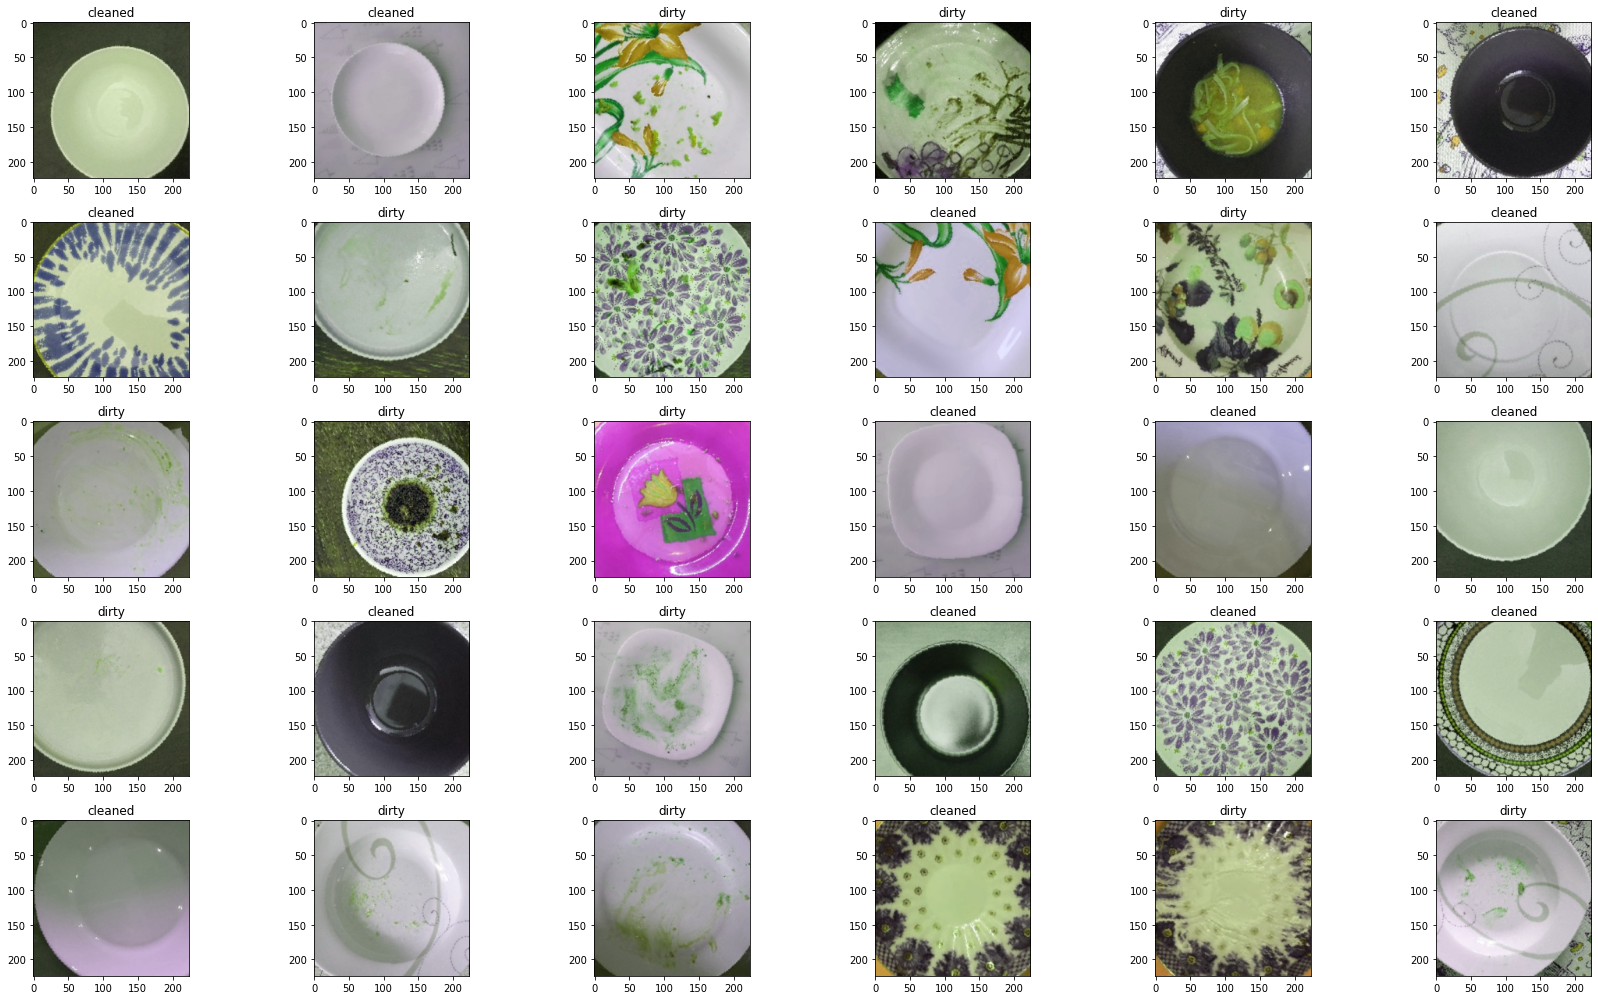

In [84]:
label_func = lambda x: CLASS_NAMES[x]

def show_input(X_batch, y_item, label_func=label_func, rows=2, figsize=(12, 7)): 
    cols = (len(X_batch) + 1) // rows
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    axes_indexer = np.indices((rows, cols)).reshape(2, -1)

    for x_item, y_item, i, j in zip(X_batch, y_item, *axes_indexer):
        image = x_item.permute(1, 2, 0).numpy()
        image = image * STD + MEAN
        
        ax[i, j].imshow(image.clip(0, 1))
        ax[i, j].set_title(label_func(y_item))

    fig.tight_layout()
    plt.show()

# все исходные данные
show_input(*next(iter(train_dataloader)), rows=5, figsize=(24, 14))

## Обучение

Относительно универсальная конструкция. Принимает:
- модель, функцию потерь, оптимизатор, планировщик шага, количество эпох

Что еще:
- `torch.set_grad_enabled(phase == 'train')` активирует изменение градиентов, которые не заморожены

In [85]:
from tqdm import tqdm
losses, accuracies = {}, {}

def train_model(model, loss, optimizer, scheduler, num_epochs, name=NAME, verbose=False):
    losses[name], accuracies[name] = {'train':[], 'val':[]}, {'train':[], 'val':[]}
    
    for epoch in tqdm(range(num_epochs)):
        if verbose: print(f"Epoch {epoch}/{num_epochs - 1}:", flush=True)
        
        if epoch == 0: 
            unfreeze(model, layers=('layer4',))
        elif epoch == 10:
            unfreeze(model, layers=('layer3', 'layer4',))
        elif epoch == 20:
            unfreeze(model, layers=('layer2', 'layer3', 'layer4',))
        elif epoch == 40:
            unfreeze(model, layers=('layer1', 'layer2', 'layer3', 'layer4',))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    # loss_value = loss(preds, labels)                        # 2 classes
                    loss_value = loss(preds.squeeze(-1), labels.float())    # 1 class (убрать измерение класса)
                    # preds_class = preds.argmax(dim=1)                       # 2 classes
                    preds_class = torch.round(preds).int()                  # 1 class (class 0 if (x <= 0.5) else class 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class.flatten() == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                scheduler.step()
            
            losses[name][phase].append(epoch_loss)
            accuracies[name][phase].append(epoch_acc.item())
            
            if verbose: print(f"[{phase}]\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}", flush=True)

    return model, losses, accuracies

# Модель

- Берем минимальный предобученный вариант ResNet
- Отключаем обновление градиентов **во всей модели**
- Последний слой меняем на полносвязный слой с 2 выходами


Это означает примерно следующее:
- из изображения вытаскиваются некоторые признаки (тензор 1х512)
- он используется как признаковое описание объекта, на основе корого обучается линейный классификатор

**Оптимизатор Adam:**
- AMSGrad - некоторая модификация, использующая более долгую память предыдущих градиентов, чем эксп.сколящее среднее
  - эмпирически замечено, что часто это ускоряет сходимость, и даже увеличивает вероятность попадания в более глубокий минимум

**Планировщик шага:**
- эмпирическое правило: часто хорошо работает постепенное уменьшение градиентного шага

In [86]:
model = models.resnet18(pretrained=True)

model.fc.in_features, model.fc.out_features

(512, 1000)

In [87]:
NUM_CLASSES = 1

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

# model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.Sigmoid(),
    torch.nn.Linear(256, NUM_CLASSES),
    torch.nn.Sigmoid(),
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [88]:
def unfreeze(model, layers=('layer3', 'layer4',), verbose=False):
    if verbose: print("Model layers:", *[name for (name, child) in model.named_children()])
    for name, child in model.named_children(): 
        if name in layers:
            if verbose: print(f"-> {name} has been unfrozen...") 
            for param in child.parameters(): 
                param.requires_grad = True 
        else: 
            for param in child.parameters(): 
                param.requires_grad = False

unfreeze(model, layers=('layer4',), verbose=True)

Model layers: conv1 bn1 relu maxpool layer1 layer2 layer3 layer4 avgpool fc
-> layer4 has been unfrozen...


In [89]:
print("Layers:", *[name for (name, child) in model.named_children()])

Layers: conv1 bn1 relu maxpool layer1 layer2 layer3 layer4 avgpool fc


In [90]:
NUM_EPOCHES = 50

loss = torch.nn.BCELoss() if NUM_CLASSES == 1 else torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 'gamma' every 'step_size' epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.8)

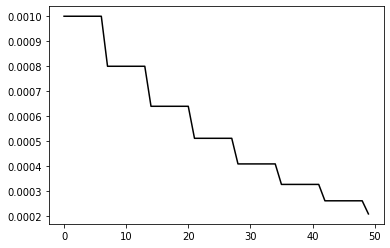

In [91]:
lrs = []
for i in range(NUM_EPOCHES):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(NUM_EPOCHES), lrs)
plt.show()

In [92]:
model, losses, accuracies = train_model(model, loss, optimizer, scheduler, num_epochs=NUM_EPOCHES)

100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


In [93]:
import matplotlib.pyplot as plt
from cycler import cycler

monochrome = (cycler('color', ['k']) * cycler('marker', ['', '.']) *
              cycler('linestyle', ['-', '--', ':', '-.']))

def acc_loss_graph(accuracies, losses, net_list):
    plt.rc('axes', prop_cycle=monochrome)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    for experiment_id in net_list:
        ax1.plot(accuracies[experiment_id]['train'], label=f"{experiment_id} train")
        ax1.plot(accuracies[experiment_id]['val'], label=f"{experiment_id} val")
    ax1.legend()
    ax1.set_title(f'Accuracy')

    for experiment_id in net_list:
        ax2.plot(losses[experiment_id]['train'], label=f"{experiment_id} train")
        ax2.plot(losses[experiment_id]['val'], label=f"{experiment_id} val")
    ax2.legend()
    ax2.set_title(f'Loss')
    
    fig.tight_layout()

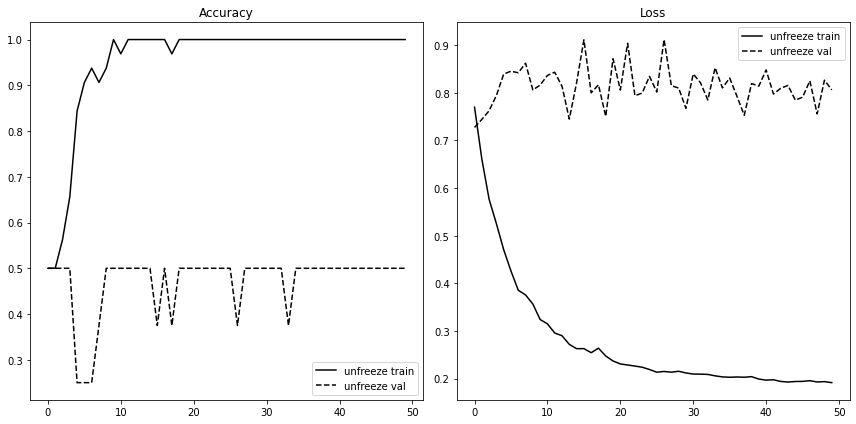

In [94]:
acc_loss_graph(accuracies, losses, [NAME])

# Сабмишшон

- делаем на тесте итератор данных

In [95]:
test_transforms = transforms.Compose([
    transforms.CenterCrop(180),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

In [96]:
import re

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index)             # (src, trg)
        path = self.imgs[index][0]
        image_id = re.search(r"([0-9]{4}).jpg$", path)[1]
        return (original_tuple[0], image_id)                    # (src, image_id)
    
test_dataset = ImageFolderWithPaths(TEST_DIR, test_transforms)

test_idx = np.arange(len(test_dataset))
np.random.shuffle(test_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

test_dataloader = get_dataloader(test_dataset, sampler=test_sampler, batch_size=256)

In [97]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: test
    StandardTransform
Transform: Compose(
               CenterCrop(size=(180, 180))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

- считаем оценки

In [98]:
model.eval()

test_predictions = []
test_image_ids = []
for inputs, image_ids in tqdm(test_dataloader):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(preds.flatten().data.cpu())
    test_image_ids.extend(image_ids)

test_predictions = torch.cat(test_predictions)

100%|██████████| 3/3 [00:07<00:00,  2.45s/it]


Доля грязных тарелков в тесте **0.65322**. Под это +/- выставляем порог классификации.
- кажется, необходимость подкручивать порог - это признак недообученности

In [113]:
DIRTY_THRESHOLD = 0.27

submission_df = pd.DataFrame.from_dict({'id': test_image_ids, 
                                        'score': test_predictions})

submission_df['label'] = submission_df['score'].map(lambda pred: 'dirty' if pred > DIRTY_THRESHOLD else 'cleaned')
submission_df.set_index('id', inplace=True)
submission_df.sort_index(inplace=True)

dirty_ratio = (submission_df['label'] == "dirty").sum() / submission_df['label'].count()
dirty_ratio

0.6545698924731183

In [114]:
submission_df["label"].to_csv(f'{NAME}-submission.csv')

Что получилось

- разморозка 4-го слоя **0.92069**
- последовательная разморозка 4-го и 3-го слоев **0.93279**
  - последовательная разморозка всей сети 0.91263

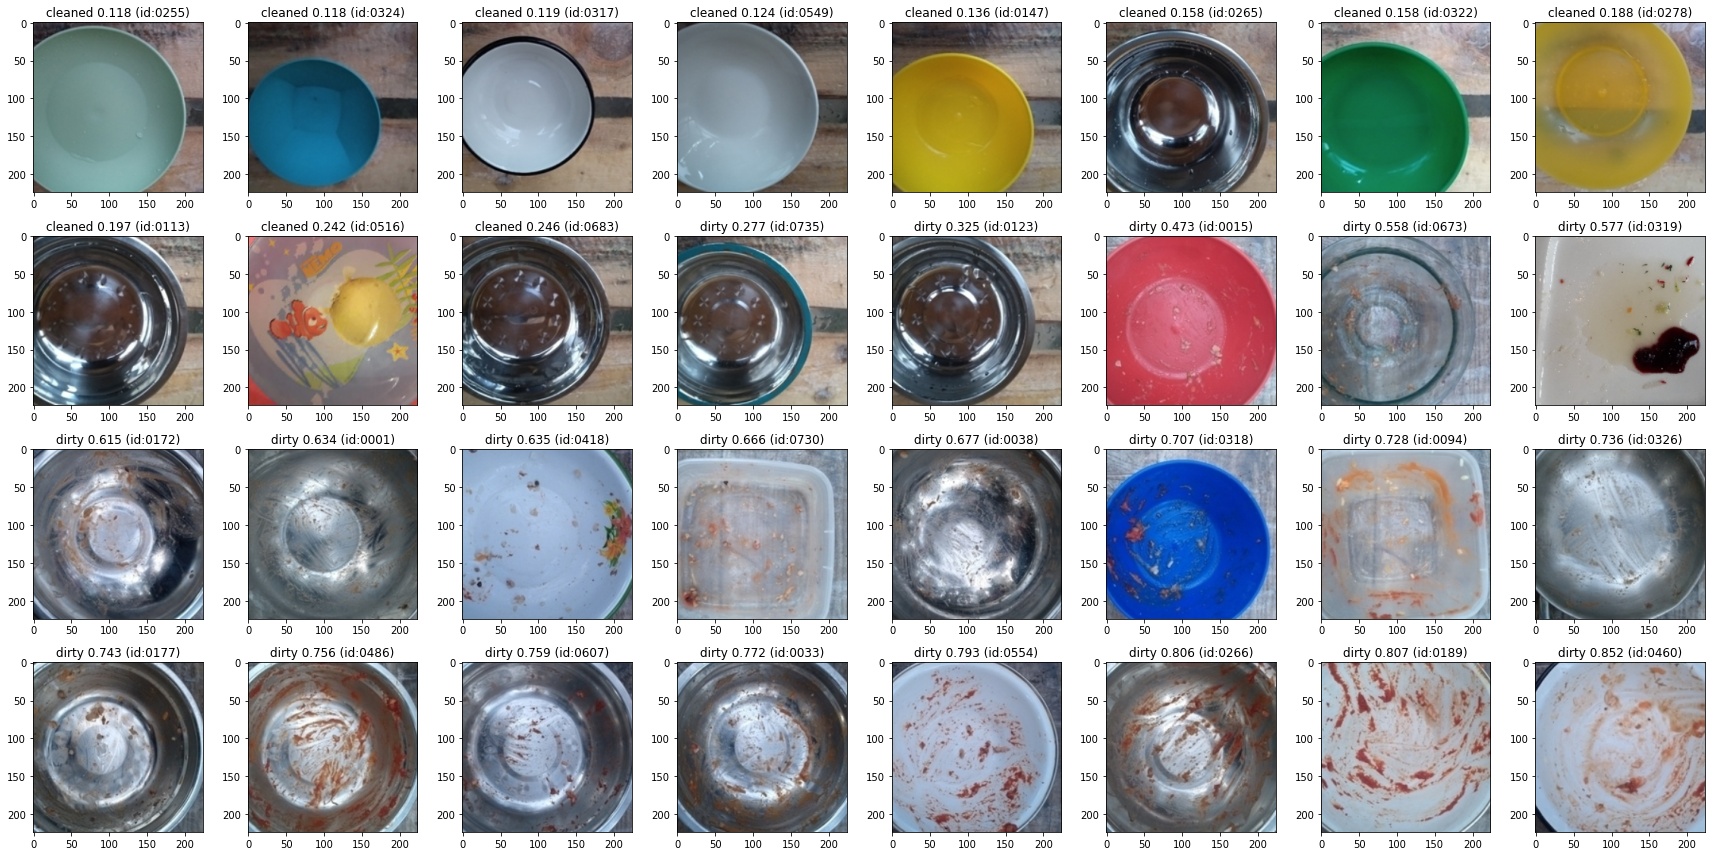

In [115]:
NUM = 32

inputs, image_ids = next(iter(test_dataloader))
inputs, image_ids = inputs[:NUM], image_ids[:NUM]

probs = submission_df.loc[np.array(image_ids)]["score"]
labels = submission_df.loc[np.array(image_ids)]["label"]

draw_set = sorted(list(zip(inputs, zip(labels, probs, image_ids))), key=lambda x: x[1][1]) # упорядочим по probs
inputs = [x[0] for x in draw_set]
labels = [x[1] for x in draw_set]

label_func = lambda x: f"{x[0]} {x[1]:.3f} (id:{x[2]})" # zip метки и вероятности в заголовок
show_input(inputs, labels, label_func=label_func, rows=4, figsize=(24,12))